In [1]:
import sys, os, imp
import numpy as np
import matplotlib.pyplot as plt

from scipy.constants import c
from IPython.display import display, Math

C:\Users\alves\AppData\Local\Temp\ipykernel_15468\2047977578.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import sys, os, imp


In [2]:
# lumapiFile = "/opt/lumerical/v221/api/python/lumapi.py"
lumapiFile = "C:\\Program Files\\Lumerical\\v221\\api\\python\\lumapi.py"
lumapi = imp.load_source("lumapi", lumapiFile)
interApi = lumapi.INTERCONNECT(hide = False)

# Parameters

In [3]:
# units
um = 1e-6
nm = 1e-9

L = 50*um
delta_L = np.array([552.82, 55.28, 27.64])*um

wavelength = 1550*um

# index
neff = 2.3531702
ng = 4.3458796

cband = True
# C Band simulation: 1520 - 1575 nm
# L Band simulation: 1555 - 1635 nm
if cband:
    wvlngth_start = 1.520 * um
    wvlngth_stop = 1.575 * um
else:
    wvlngth_start = 1.555 * um
    wvlngth_stop = 1.635 * um


# Add Devices  

In [4]:
interApi.switchtolayout()
interApi.select('ONA')
interApi.delete()

# ONA

interApi.addelement('Optical Network Analyzer')
interApi.set('name', 'ONA')
interApi.set('number of input ports', 2)
interApi.set('input parameter', 2)
interApi.set('start frequency', c/wvlngth_start)
interApi.set('stop frequency', c/wvlngth_stop)

## $FSR(\lambda) = 1nm$

In [5]:
interApi.switchtolayout()
interApi.select('coupler_1')
interApi.delete()
interApi.select('coupler_2')
interApi.delete()
interApi.select('wg_1')
interApi.delete()
interApi.select('wg_2')
interApi.delete()

# Waveguide

interApi.addelement('Waveguide Coupler')
interApi.set('name', 'coupler_1')

interApi.addelement('Waveguide Coupler')
interApi.set('name', 'coupler_2')

interApi.addelement('Straight Waveguide')
interApi.set('name', 'wg_1')
interApi.set('frequency', (c/(wavelength)))
interApi.set('length', L)
interApi.set('effective index 1', neff)
interApi.set('group index 1', ng)


interApi.addelement('Straight Waveguide')
interApi.set('name', 'wg_2')
interApi.set('frequency', (c/(wavelength)))
interApi.set('length', L + delta_L[0])
interApi.set('effective index 1', neff)
interApi.set('group index 1', ng)

In [20]:
#positions
interApi.setposition('ONA', 0, -400)
interApi.setposition('wg_1', 0,-100)
interApi.setposition('wg_2', 0, 100)
interApi.setposition('coupler_1', -250, 50)
interApi.setposition('coupler_2', 250, 50)

In [ ]:
# connection

interApi.connect("ONA", "output", "coupler_1", "port 1")
interApi.connect("coupler_1", "port 3", "wg_1", "port 1")
interApi.connect("coupler_1", "port 4", "wg_2", "port 1")
interApi.connect("wg_1", "port 2", "coupler_2", "port 1")
interApi.connect("wg_2", "port 2", "coupler_2", "port 2")
interApi.connect("coupler_2", "port 3", "ONA", "input 1")
interApi.connect("coupler_2", "port 4", "ONA", "input 2")

1.0

In [19]:
interApi.run()

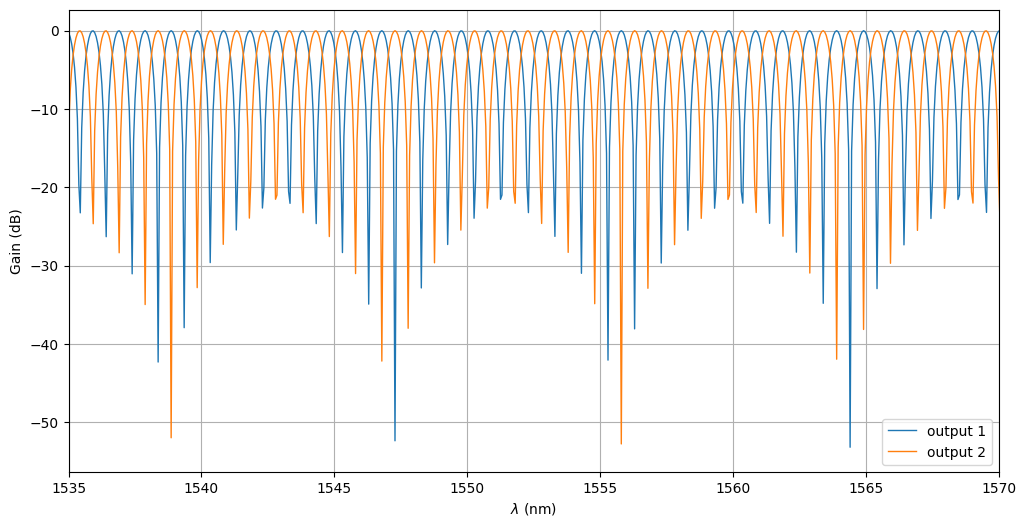

In [ ]:
gain = interApi.getresult("ONA", "input 1/mode 1/gain")
wavelength_1 = gain['wavelength']
gain = gain['TE gain (dB)']

gain_2 = interApi.getresult("ONA", "input 2/mode 1/gain")
wavelength_2 = gain_2['wavelength']
gain_2 = gain_2['TE gain (dB)']

plt.figure(figsize=(12, 6))
plt.plot(wavelength_1/nm, gain, lw = 1, label='output 1')
plt.plot(wavelength_2/nm, gain_2, lw = 1, label='output 2')
plt.xlabel('$\lambda$ (nm)')
plt.ylabel('Gain (dB)')
plt.xlim([1535, 1570])
plt.grid()
plt.legend(loc='best')
plt.show()

plt